In [1]:
import ngsolve as ngs
import numpy as np
import matplotlib.pyplot as plt
from ngsolve.webgui import Draw
from netgen.geom2d  import SplineGeometry

from math import pi

In [7]:
beta = 2
R = 1
order = 1
h = 0.1

r = ngs.sqrt(ngs.x ** 2 + ngs.y ** 2)
phi = pi / 2 - ngs.IfPos(-ngs.y, ngs.IfPos(-ngs.x, ngs.atan2(ngs.x, ngs.y), ngs.IfPos(ngs.x, ngs.atan2(ngs.x, ngs.y), -pi)), ngs.atan2(ngs.x, ngs.y))

ex_sol = (R ** 2 - r ** 2) * r ** beta * ngs.sin(phi * beta)
rhs = (4 * beta + 4) * r ** beta * ngs.sin(phi * beta)

ex_sol_grad = ngs.CoefficientFunction(
    (
        ex_sol.Diff(ngs.x),
        ex_sol.Diff(ngs.y)
    )
)

eps = 1e-8
r_eps = ngs.sqrt(
    (ngs.x + eps) ** 2 + (ngs.y + eps) ** 2
)

grad_eps = ((R**2-r_eps**2)*beta*r_eps**(beta-1)*ngs.sin(phi*beta)-2*r_eps**(beta+1)*ngs.sin(phi*beta))*ngs.CoefficientFunction( (ngs.cos(phi),ngs.sin(phi)) ) + beta*(R**2-r_eps**2)*r_eps**(beta-1)*ngs.cos(phi*beta)*ngs.CoefficientFunction( (-ngs.sin(phi),ngs.cos(phi)) )
sol_grad = ngs.IfPos(r, ex_sol_grad, grad_eps)

geo = SplineGeometry()
#pnts = [(0, 0), (R, 0), (R, R), (0, R), (-R, R), (-R, 0), (-R, -R), (0, -R)]
pnts = [(0, 0), (R, 0), (R, R), (0, R)]

pind = [geo.AppendPoint(*pnt) for pnt in pnts]

# (Control-) Point positions
#  4        3        2
#           
#
#
#  5        0        1
#           
#           
#           
#  6        7

# line from pind[0] to pind[1]
geo.Append(['line', pind[0], pind[1]], bc = "outer")

# spline from point pind[1] to pind[3] with control point pind[2]
geo.Append(['spline3', pind[1], pind[2], pind[3]], bc = "outer")

 # spline from point pind[3] to pind[5] with control point pind[4]
#geo.Append(['spline3', pind[3], pind[4], pind[5]], bc = "outer")

# spline from point pind[5] to pind[7] with control point pind[6]
#geo.Append(['spline3', pind[5], pind[6], pind[7]], bc = "outer")

# line from pind[7] to pind[0]
#geo.Append(['line', pind[7], pind[0]], bc = "outer")

# line from pind[3] to pind[0]
geo.Append(['line', pind[3], pind[0]], bc = "outer")


# -------------------------------- #

mesh = ngs.Mesh(geo.GenerateMesh(maxh = h))
mesh.Curve(order)
        
fes = ngs.H1(mesh, order = order, dirichlet = "outer", autoupdate = True)
sol = ngs.GridFunction(fes, autoupdate = True)
fe_ag = ngs.VectorH1(mesh, order = order, autoupdate = True)
vtilde = ngs.GridFunction(fe_ag, autoupdate = True)
        
u, v = fes.TnT()

a = ngs.BilinearForm(fes, symmetric = True)
a += ngs.grad(u) * ngs.grad(v) * ngs.dx
a.Assemble()

f = ngs.LinearForm(fes)
f += rhs * v * ngs.dx
f.Assemble()

#Draw(mesh)

err_arr = []
ndof_arr = []


sol.vec.data = a.mat.Inverse(freedofs = fes.FreeDofs()) * f.vec
err_arr.append(ngs.sqrt(ngs.Integrate((ex_sol-sol)**2 + ngs.InnerProduct(ex_sol_grad - ngs.grad(sol),ex_sol_grad - ngs.grad(sol)),mesh, ngs.VOL, 2*order)))
ndof_arr.append(fes.ndof)
flux = ngs.grad(sol)
vtilde.Set(flux)


Draw(ex_sol - sol, mesh, "sol")

eta = ngs.Integrate(ngs.InnerProduct(ngs.grad(sol) - vtilde, ngs.grad(sol) - vtilde), mesh, ngs.VOL, element_wise = True)
eta_num = eta.NumPy()
eta_num = np.sqrt(eta_num)

while np.linalg.norm(eta_num) > 1e-2:
    sol.vec.data = a.mat.Inverse(freedofs = fes.FreeDofs()) * f.vec
    err_arr.append(ngs.sqrt(ngs.Integrate((ex_sol-sol)**2 + ngs.InnerProduct(ex_sol_grad - ngs.grad(sol),ex_sol_grad - ngs.grad(sol)),mesh, ngs.VOL, 2*order)))
    ndof_arr.append(fes.ndof)
    flux = ngs.grad(sol)
    vtilde.Set(flux)
    
    
    Draw(ex_sol - sol, mesh, "sol")

    eta = ngs.Integrate(ngs.InnerProduct(ngs.grad(sol) - vtilde, ngs.grad(sol) - vtilde), mesh, ngs.VOL, element_wise = True)
    maxerr = max(eta)
    
    eta_num = eta.NumPy()
    errnr = []
    sum1 = 0
    for el in mesh.Elements():
        errnr.append([eta_num[el.nr],el.nr])
        sum1 += eta_num[el.nr]
        
    errnr.sort(key = lambda x: x[0], reverse = True)
    
    sum2 = 0
    i = 0
    refinement_arr = []
    while sum2 < sum1*0.25:
        sum2 += errnr[i][0]
        refinement_arr.append(errnr[i][1])
        i += 1
    
    for el in mesh.Elements():
        mesh.SetRefinementFlag(el,el.nr in refinement_arr)

    eta_num = np.sqrt(eta_num)
    mesh.Refine()
    a.Assemble()
    f.Assemble()
    mesh.Curve(order)
    #Draw(mesh)

NGSWebGuiWidget(value={'ngsolve_version': '6.2.2008', 'mesh_dim': 2, 'order2d': 2, 'order3d': 2, 'draw_vol': F…

NGSWebGuiWidget(value={'ngsolve_version': '6.2.2008', 'mesh_dim': 2, 'order2d': 2, 'order3d': 2, 'draw_vol': F…

NGSWebGuiWidget(value={'ngsolve_version': '6.2.2008', 'mesh_dim': 2, 'order2d': 2, 'order3d': 2, 'draw_vol': F…

NGSWebGuiWidget(value={'ngsolve_version': '6.2.2008', 'mesh_dim': 2, 'order2d': 2, 'order3d': 2, 'draw_vol': F…

NGSWebGuiWidget(value={'ngsolve_version': '6.2.2008', 'mesh_dim': 2, 'order2d': 2, 'order3d': 2, 'draw_vol': F…

NGSWebGuiWidget(value={'ngsolve_version': '6.2.2008', 'mesh_dim': 2, 'order2d': 2, 'order3d': 2, 'draw_vol': F…

NGSWebGuiWidget(value={'ngsolve_version': '6.2.2008', 'mesh_dim': 2, 'order2d': 2, 'order3d': 2, 'draw_vol': F…

NGSWebGuiWidget(value={'ngsolve_version': '6.2.2008', 'mesh_dim': 2, 'order2d': 2, 'order3d': 2, 'draw_vol': F…

NGSWebGuiWidget(value={'ngsolve_version': '6.2.2008', 'mesh_dim': 2, 'order2d': 2, 'order3d': 2, 'draw_vol': F…

NGSWebGuiWidget(value={'ngsolve_version': '6.2.2008', 'mesh_dim': 2, 'order2d': 2, 'order3d': 2, 'draw_vol': F…

NGSWebGuiWidget(value={'ngsolve_version': '6.2.2008', 'mesh_dim': 2, 'order2d': 2, 'order3d': 2, 'draw_vol': F…

NGSWebGuiWidget(value={'ngsolve_version': '6.2.2008', 'mesh_dim': 2, 'order2d': 2, 'order3d': 2, 'draw_vol': F…

NGSWebGuiWidget(value={'ngsolve_version': '6.2.2008', 'mesh_dim': 2, 'order2d': 2, 'order3d': 2, 'draw_vol': F…

NGSWebGuiWidget(value={'ngsolve_version': '6.2.2008', 'mesh_dim': 2, 'order2d': 2, 'order3d': 2, 'draw_vol': F…

NGSWebGuiWidget(value={'ngsolve_version': '6.2.2008', 'mesh_dim': 2, 'order2d': 2, 'order3d': 2, 'draw_vol': F…

NGSWebGuiWidget(value={'ngsolve_version': '6.2.2008', 'mesh_dim': 2, 'order2d': 2, 'order3d': 2, 'draw_vol': F…

In [3]:
beta = 2
R = 1

r = ngs.sqrt(ngs.x ** 2 + ngs.y ** 2)
phi = pi / 2 - ngs.IfPos(-ngs.y, ngs.IfPos(-ngs.x, ngs.atan2(ngs.x, ngs.y), ngs.IfPos(ngs.x, ngs.atan2(ngs.x, ngs.y), -pi)), ngs.atan2(ngs.x, ngs.y))

ex_sol = (R ** 2 - r ** 2) * r ** beta * ngs.sin(phi * beta)
rhs = (4 * beta + 4) * r ** beta * ngs.sin(phi * beta)

ex_sol_grad = ngs.CoefficientFunction(
    (
        ex_sol.Diff(ngs.x),
        ex_sol.Diff(ngs.y)
    )
)

eps = 1e-8
r_eps = ngs.sqrt(
    (ngs.x + eps) ** 2 + (ngs.y + eps) ** 2
)

grad_eps = ((R**2-r_eps**2)*beta*r_eps**(beta-1)*ngs.sin(phi*beta)-2*r_eps**(beta+1)*ngs.sin(phi*beta))*ngs.CoefficientFunction( (ngs.cos(phi),ngs.sin(phi)) ) + beta*(R**2-r_eps**2)*r_eps**(beta-1)*ngs.cos(phi*beta)*ngs.CoefficientFunction( (-ngs.sin(phi),ngs.cos(phi)) )
sol_grad = ngs.IfPos(r, ex_sol_grad, grad_eps)

geo = SplineGeometry()
#pnts = [(0, 0), (R, 0), (R, R), (0, R), (-R, R), (-R, 0), (-R, -R), (0, -R)]
pnts = [(0, 0), (R, 0), (R, R), (0, R)]

pind = [geo.AppendPoint(*pnt) for pnt in pnts]

# (Control-) Point positions
#  4        3        2
#           
#
#
#  5        0        1
#           
#           
#           
#  6        7

# line from pind[0] to pind[1]
geo.Append(['line', pind[0], pind[1]], bc = "outer")

# spline from point pind[1] to pind[3] with control point pind[2]
geo.Append(['spline3', pind[1], pind[2], pind[3]], bc = "outer")

 # spline from point pind[3] to pind[5] with control point pind[4]
#geo.Append(['spline3', pind[3], pind[4], pind[5]], bc = "outer")

# spline from point pind[5] to pind[7] with control point pind[6]
#geo.Append(['spline3', pind[5], pind[6], pind[7]], bc = "outer")

# line from pind[7] to pind[0]
#geo.Append(['line', pind[7], pind[0]], bc = "outer")

# line from pind[3] to pind[0]
geo.Append(['line', pind[3], pind[0]], bc = "outer")


# -------------------------------- #

h_array = [2 ** -n for n in range(7)]
ndof_array = []
error_array = []
    
for h in h_array:
        
    mesh = ngs.Mesh(geo.GenerateMesh(maxh = h))
    mesh.Curve(order)
        
    fes = ngs.H1(mesh, order = order, dirichlet = "outer")
    sol = ngs.GridFunction(fes)
        
    u, v = fes.TnT()

    a = ngs.BilinearForm(fes, symmetric = True)
    a += ngs.grad(u) * ngs.grad(v) * ngs.dx
    a.Assemble()

    f = ngs.LinearForm(fes)
    f += rhs * v * ngs.dx
    f.Assemble()

    sol.vec.data = a.mat.Inverse(freedofs = fes.FreeDofs(), inverse="sparsecholesky") * f.vec
    if h == 2**-4 and order == 1:
        Draw(ex_sol - sol, mesh, "sol")
    H1err = ngs.sqrt(
        ngs.Integrate(
            (ex_sol - sol) ** 2 + ngs.InnerProduct(
                ex_sol_grad - ngs.Grad(sol),
                ex_sol_grad - ngs.Grad(sol)
            ),
            mesh
        )
    )

    error_array.append(H1err)
    ndof_array.append(fes.ndof)

NGSWebGuiWidget(value={'ngsolve_version': '6.2.2008', 'mesh_dim': 2, 'order2d': 2, 'order3d': 2, 'draw_vol': F…

<IPython.core.display.Javascript object>


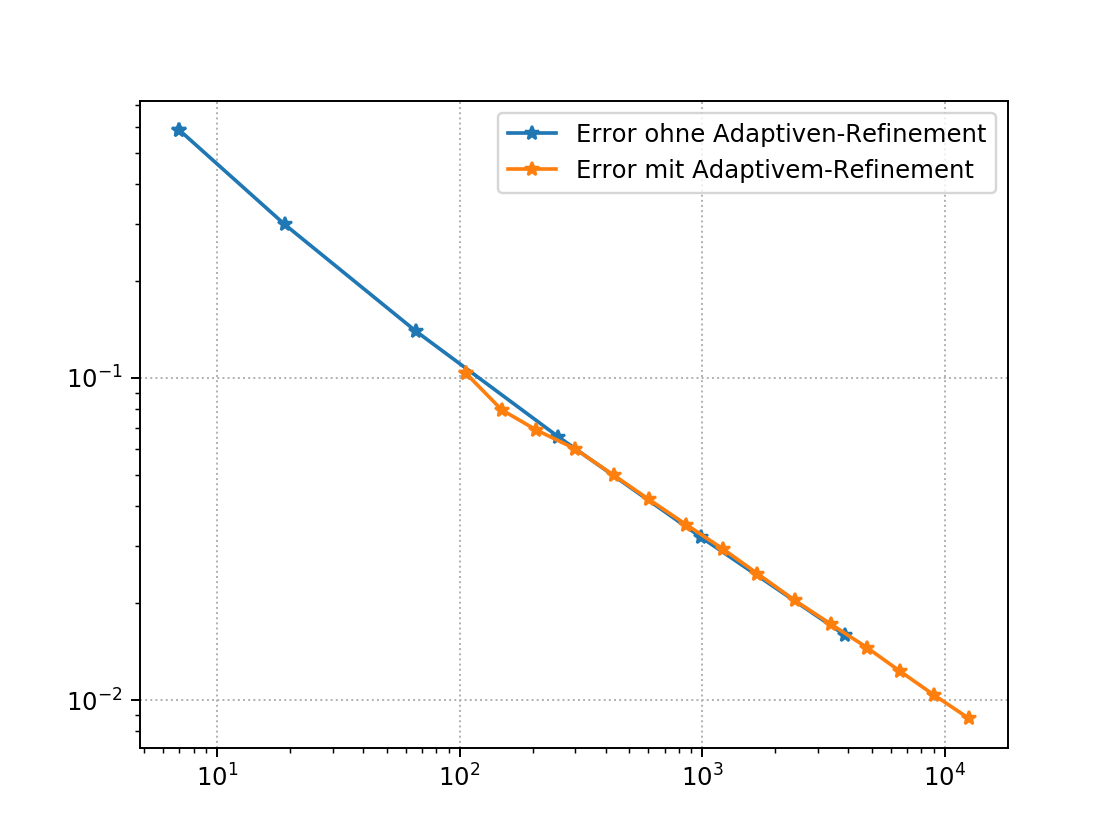

In [8]:
%matplotlib notebook

plt.loglog(ndof_array, error_array, "-*", label = "Error ohne Adaptiven-Refinement")
plt.loglog(ndof_arr,err_arr, "-*", label = "Error mit Adaptivem-Refinement")

plt.legend()
plt.grid(linestyle = ':')
plt.show()